# Sparkify Data Analysis and Prediction of Churn

In the notebook below, we provide an analysis of the "mini_sparkify_event_data" data set, a sample of data from a hypothetical music streaming service (similar to Pandora or Spotify). We attempt to develop a model to anticipate **churn**, i.e. cancellation of the service. The analysis is performed using pySpark.


## Launch Spark Session

In [1]:
# Import needed libraries here
import seaborn as sns
from pyspark.sql import SparkSession
import  pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, count, udf
from pyspark.sql.types import IntegerType, BooleanType, StringType
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import broadcast
import matplotlib.pyplot as plt
from functools import reduce
import time


In [2]:
# Launch Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

## Read Data

In [3]:
# Read in the data set
sdf = spark.read.json('mini_sparkify_event_data.json') ## Read into Spark Dataframe
sdf.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

## 1. Initial Look at Data 

### 1.1 Describe Data Shape and Fields

In [4]:
print("Number of rows = ",sdf.count())
print("Number of columns = ",len(sdf.columns))
print("Columns Headings and Types")
sdf.printSchema()

Number of rows =  286500
Number of columns =  18
Columns Headings and Types
root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### 1.2 Field Descriptions

Here we give a heads up on field descriptions, some of which may not be obvious
but will be discovered later.

Field Name                 |  Field Description
:-------------------------:|:-------------------------:
ts                         |  Timestamp of page access (Unix Time milliseconds since 1/1/1970)
userId                     |  Unique id for userId, known if user is logged in
sessionId                  |  Id number for session, definition of session is somewhat unclear
page                       |  Particular type of page being accessed, e.g. Home, NextSong, About, ...
auth                       |  Authorization: 'Logged In', 'Logged Out', 'Guest', 'Cancelled'
method                     |  HTTP Reguest, either GET or PUT 
status                     |  Return status from request, 200 (OK),  404(Error:Page not Found), (307) Redirect
level                      |  'free' ('paid'): user streams with (without) advertisements
itemInSession              |  Sequence id of page access in session
location                   |  Location of userAgent
userAgent                  |  Agent (webbrowser,OS) used to access page
lastName                   |  Last name  of user 
firstName                  |  First name of user
registration               |  Timestamp of when user registered with service (Unit Time)
gender                     |  Gender of user: 'M' (Male) or 'F' (Female)
artist                     |  Artist of song being listened to if on page='NextSong'
song                       |  Name of song  being listened to if on page='NextSong'
length                     |  Length of song in seconds


#### Each row essentially represents a webpage access by some user, represented by the userId field. 

In [5]:
## Example sample for userId=4 (Warren Miller)
sdf.filter(sdf.userId=='4').toPandas()[0:10]

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Dwight Yoakam,Logged In,Warren,M,0,Miller,239.30730,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,You're The One,200,1538356650000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
1,None,Logged In,Warren,M,1,Miller,NaN,free,"Baltimore-Columbia-Towson, MD",PUT,Logout,1538169823000,240,None,307,1538356651000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
2,None,Logged In,Warren,M,4,Miller,NaN,free,"Baltimore-Columbia-Towson, MD",GET,Home,1538169823000,240,None,200,1538356686000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
3,Parachute,Logged In,Warren,M,5,Miller,221.67465,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,Ghost,200,1538356889000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
4,None,Logged In,Warren,M,6,Miller,NaN,free,"Baltimore-Columbia-Towson, MD",GET,Home,1538169823000,240,None,200,1538356954000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
5,Jason Mraz,Logged In,Warren,M,7,Miller,218.40934,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,Geek In The Pink [Phil Tan Remix],200,1538357110000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
6,Mastodon,Logged In,Warren,M,8,Miller,215.97995,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,The Wolf Is Loose (Album Version),200,1538357328000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
7,Dead Can Dance,Logged In,Warren,M,9,Miller,203.91138,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,The Promised Womb (Remastered),200,1538357543000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
8,En Vogue,Logged In,Warren,M,10,Miller,250.46159,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,Free Your Mind,200,1538357746000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4
9,Linkin Park,Logged In,Warren,M,11,Miller,268.61669,free,"Baltimore-Columbia-Towson, MD",PUT,NextSong,1538169823000,240,New Divide (Album Version),200,1538357996000,Mozilla/5.0 (Windows NT 6.0; rv:31.0) Gecko/20...,4


### 1.3 Definition of Churn

We define **churn** as the access of the 'Cancel Confirmation' page, 
sdf.page = 'Cancel Confirmation', always preceded by access of the 'Cancel' page. In this notebook we refer
to the set of data corresponding to users in churn as the *cancel set* and remaining data as the *stay set*.

## 2 Exploratory Analysis and Feature Discovery

#### *We examine the data field by field, attempting to determine features that can discriminiate users in the cancel set from those in the stay set.*

### 2.1 Get unique count of userIds

In [6]:
sdf.agg(F.countDistinct(sdf.userId)).collect()

[Row(count(DISTINCT userId)=226)]

### 2.2 Rows with no userId

#### *We expect userIds to be made up of digits, find those that are not. The rows shown in the next cell are those that are not null when there is no userId.*

In [7]:
# Return rows with missing userIds
def is_digit(value):
    return value.isdigit()

is_digit_udf = udf(is_digit, BooleanType())
sdf_mid  = sdf.filter(~is_digit_udf(sdf.userId))
sdf_mid1 = sdf_mid.select('userId', 'sessionId','page',
            'auth','method','status','level','itemInSession')
sdf_mid1.limit(5).toPandas()

,userId,sessionId,page,auth,method,status,level,itemInSession
0,,8,Home,Logged Out,GET,200,free,100
1,,8,Help,Logged Out,GET,200,free,101
2,,8,Home,Logged Out,GET,200,free,102
3,,8,Login,Logged Out,PUT,307,free,103
4,,240,Home,Logged Out,GET,200,free,2


#### *Explanation:*
#### These rows correspond to page accesses where the userId is empty (unknown). All other fields are specific to the user and are thus null when the userId is missing. 

In [8]:
# Show that these fields are always null when the userId is missing.
sdf_mid2 = sdf_mid.select('userId', 'gender','location','lastName','firstName',
                          'registration','artist','song','length')

sdf_mid2.show(5)
print("Number of rows with missing userId = ",sdf_mid2.count())
print("\n\nNumber of nulls for each field")
sdf_mid2.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sdf_mid2.columns]).limit(5).toPandas()

+------+------+--------+--------+---------+------------+------+----+------+
|userId|gender|location|lastName|firstName|registration|artist|song|length|
+------+------+--------+--------+---------+------------+------+----+------+
|      |  null|    null|    null|     null|        null|  null|null|  null|
|      |  null|    null|    null|     null|        null|  null|null|  null|
|      |  null|    null|    null|     null|        null|  null|null|  null|
|      |  null|    null|    null|     null|        null|  null|null|  null|
|      |  null|    null|    null|     null|        null|  null|null|  null|
+------+------+--------+--------+---------+------------+------+----+------+
only showing top 5 rows

Number of rows with missing userId =  8346


Number of nulls for each field


,userId,gender,location,lastName,firstName,registration,artist,song,length
0,0,8346,8346,8346,8346,8346,8346,8346,8346


In [9]:
print("Number of rows with missing userId = ",sdf_mid2.count())
print("\n\nNumber of nulls for each field")
sdf_mid2.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sdf_mid2.columns]).limit(5).toPandas()

Number of rows with missing userId =  8346


Number of nulls for each field


,userId,gender,location,lastName,firstName,registration,artist,song,length
0,0,8346,8346,8346,8346,8346,8346,8346,8346


#### *The missing userIds account for only 8346/286500 = 2.9% of the total data. We can get more information by looking at the 'auth' field*.

### 2.3 Field *'auth'*  (missing userId)

In [10]:
## Print unique values of 'auth' when userId is missing
sdf_mid1.groupBy('auth').count().orderBy('count').collect()

[Row(auth='Guest', count=97), Row(auth='Logged Out', count=8249)]

#### There are only two unique values for *'auth'* field when userId is not present:        'Guest' and 'Logged Out'.
#### We might ask if it is possible to restore userIds, so that we are tracking them when 'Logged Out'. 
#### For example

In [11]:
sdf.filter((sdf.sessionId == 240)  & (sdf.itemInSession < 7)) \
   .select("ts","userId","sessionId","itemInSession","page","auth").toPandas()

,ts,userId,sessionId,itemInSession,page,auth
0,1538356650000,4,240,0,NextSong,Logged In
1,1538356651000,4,240,1,Logout,Logged In
2,1538356678000,,240,2,Home,Logged Out
3,1538356679000,,240,3,Login,Logged Out
4,1538356686000,4,240,4,Home,Logged In
5,1538356889000,4,240,5,NextSong,Logged In
6,1538356954000,4,240,6,Home,Logged In
7,1540798031000,200016,240,0,Home,Logged In
8,1540798229000,200016,240,1,NextSong,Logged In
9,1540798549000,200016,240,2,NextSong,Logged In


#### Description:
#### Note in the above that userId=4 logs out, then logs in, listens to a song (NextSong), and then goes back to home, all the while itemInSession increments. However, using userId,sessionId, and itemInSession to fill in missing userIds is not foolproof, since more than one user can be associated with a single sessionId, as can be seen above.

#### Based on these facts, we choose to eliminate rows with missing userIds

In [12]:
# Eliminate rows with missing userIds
sdf = sdf.filter(sdf.userId != '')

### 2.4 Field *'auth'*  (present userId)

In [13]:
# Unique auth fields when the userId is present.
print("Unique auth fields when the userId is present.")
sdf.groupBy('auth').count().orderBy('count').collect()

Unique auth fields when the userId is present.


[Row(auth='Cancelled', count=52), Row(auth='Logged In', count=278102)]

In [14]:
print("Consder the case where auth=Cancelled...")
### Subset auth='Canceled'
sdf.filter(sdf.auth=='Cancelled').select('userId','auth','page').show(10)

Consder the case where auth=Cancelled...
+------+---------+--------------------+
|userId|     auth|                page|
+------+---------+--------------------+
|    18|Cancelled|Cancellation Conf...|
|    32|Cancelled|Cancellation Conf...|
|   125|Cancelled|Cancellation Conf...|
|   105|Cancelled|Cancellation Conf...|
|    17|Cancelled|Cancellation Conf...|
|   143|Cancelled|Cancellation Conf...|
|   101|Cancelled|Cancellation Conf...|
|   129|Cancelled|Cancellation Conf...|
|   121|Cancelled|Cancellation Conf...|
|    51|Cancelled|Cancellation Conf...|
+------+---------+--------------------+
only showing top 10 rows



#### We can show that when auth = 'Cancelled', page = 'Cancellation Confirmation' always

In [15]:
# Get distinct values of page field when auth = 'Cancelled'
sdf.filter(sdf.auth=='Cancelled').select('page').distinct().collect()

[Row(page='Cancellation Confirmation')]

#### In all other instances page='Logged In'. As a result, the 'auth' field doesn't provide useful distinguishing information (that we don't already have from the 'page' field) and so we drop it here.

In [16]:
sdf=sdf.drop('auth')

### 2.5 Fields 'method' and 'status'

In [17]:
# Get all distinct (in-row) combinations of the fields
# 'page','method', and 'status'
sdf.select('page','method','status').distinct().toPandas()

,page,method,status
0,Submit Upgrade,PUT,307
1,Upgrade,GET,200
2,Downgrade,GET,200
3,Cancellation Confirmation,GET,200
4,Submit Downgrade,PUT,307
5,Add to Playlist,PUT,200
6,Save Settings,PUT,307
7,Thumbs Up,PUT,307
8,Home,GET,200
9,Logout,PUT,307


#### Explanation:
#### Note in the above that there is only method value and one return status value for each page type. So the page type gives as much and more specific information. There is no reason that using the aggregates ('PUT','307') or ('GET','200') apart from individual page types would be helpful, e.g. Roll Advert and Home are quite unrelated, as is 'Logout' and 'Friend'.

#### Therefore, we drop the method and status fields.

In [18]:
## So we drop the method and status fields as well as firstName and lastName since we have
## the userId to uniquely identify the user
sdf=sdf.drop(*['method','status'])

### 2.6 Fields 'lastName' and 'firstName'

#### There is no reason to believe these will have any bearing on a users decision to cancel, so we drop them as well.

In [19]:
sdf=sdf.drop(*['firstName','lastName'])

### 2.7 Identify Cancelling (churn) Users

In [20]:
# Make dataframes with 'canceling' and 'staying' users
users_all_sdf    = sdf.select('userId').distinct()  
users_cancel_sdf = sdf.filter(sdf.page == 'Cancellation Confirmation').select('userId').distinct()
users_stay_sdf    = users_all_sdf.join(users_cancel_sdf,on='userId',how='left_anti')

numUsers = users_all_sdf.count()
print("Number of unique users = ",users_all_sdf.count())
print("Number of cancelling users = ",users_cancel_sdf.count())
print("Number of staying    users = ", users_stay_sdf.count())
#print("Percentage of users in churn = ",)

Number of unique users =  225
Number of cancelling users =  52
Number of staying    users =  173


### 2.8 Field 'level' 

#### There are two distinct values of the 'level' field: 'free' and 'paid'. Users subscribed at the free level are occasionally served up advertisements at the beginning of a song. 

In [21]:
#  The 'level' field -- get count of distinct values
sdf_levels = sdf.select('userId','level').distinct()
sdf_levels.groupBy('level').count().orderBy('count').collect()

[Row(level='paid', count=165), Row(level='free', count=195)]

#### Note some users have been at both levels at different times.

In [22]:
# Breakdown free and paying subscribers among the cancel and stay sets.
users_free_sdf =  sdf_levels.filter(sdf_levels.level=='free').select('userId')
users_paid_sdf =  sdf_levels.filter(sdf_levels.level=='paid').select('userId')

free_cancel_users_sdf = users_free_sdf.join(users_cancel_sdf,on='userId',how='inner')
free_stay_users_sdf   = users_free_sdf.join(users_stay_sdf,  on='userId',how='inner')

paid_cancel_users_sdf = users_paid_sdf.join(users_cancel_sdf,on='userId',how='inner')
paid_stay_users_sdf   = users_paid_sdf.join(users_stay_sdf,  on='userId',how='inner')

freepaid_cancel_users = free_cancel_users_sdf.join(paid_cancel_users_sdf,on='userId',how='inner')
freepaid_stay_users   = free_stay_users_sdf.join(paid_stay_users_sdf,on='userId',how='inner')


fcu = free_cancel_users_sdf.count()
fsu = free_stay_users_sdf.count()
pcu = paid_cancel_users_sdf.count()
psu = paid_stay_users_sdf.count()

fpcu = freepaid_cancel_users.count()
fpsu = freepaid_stay_users.count()

print("Cancelling Users -----------------------------------")
print("Total free      cancelling users = ",fcu)
print("      free+paid cancelling users = ",fpcu)
print("      free only cancelling users = ",fcu-fpcu)
print("Total paid      cancelling users = ",pcu)
print("      paid only cancelling users = ",pcu-fpcu)
print("\n")
print("Staying    Users -----------------------------------")
print("Total free      staying    users = ",fsu)
print("      free+paid staying    users = ",fpsu)
print("      free only staying    users = ",fsu-fpsu)
print("Total paid      staying    users = ",psu)
print("      paid only staying    users = ",psu-fpsu)
print("\n")
print("free only /paid only   cancel users = ", "{0:.2f}".format((fcu-fpcu)/(pcu-fpcu)))
print("free only /paid only   stay   users = ", "{0:.2f}".format((fsu-fpsu)/(psu-fpsu)))

Cancelling Users -----------------------------------
Total free      cancelling users =  46
      free+paid cancelling users =  30
      free only cancelling users =  16
Total paid      cancelling users =  36
      paid only cancelling users =  6


Staying    Users -----------------------------------
Total free      staying    users =  149
      free+paid staying    users =  105
      free only staying    users =  44
Total paid      staying    users =  129
      paid only staying    users =  24


free only /paid only   cancel users =  2.67
free only /paid only   stay   users =  1.83


#### The percentage of users in the cancelling set that have been at both levels is roughly equal to the same in staying set.
####  30 out of 52 cancel users were free and paid at one time (0.57), whereas 105 out of (105 + 68) staying users were both free and paid at one time (0.60)

####  The ratio of free only to paid only cancelling users is significantly large that the same ratio for staying users

#### So the 'level' field may be important

### 2.9 Field 'gender'

In [23]:
## Breakdown male, female users in the cancel and stay sets.
users_gender_sdf   = sdf.select('userId','gender').distinct()
users_male_sdf     = users_gender_sdf.filter(users_gender_sdf.gender=='M').select('userId')
users_female_sdf   = users_gender_sdf.filter(users_gender_sdf.gender=='F').select('userId')

## Join to users_cancel,users_stay
umc =   users_male_sdf.join(users_cancel_sdf, on='userId', how='inner').count()
ufc = users_female_sdf.join(users_cancel_sdf, on='userId', how='inner').count()
ump =   users_male_sdf.join(users_stay_sdf,   on='userId', how='inner').count()
ufp = users_female_sdf.join(users_stay_sdf,   on='userId', how='inner').count()

print("Number of male users = ", umc + ump)
print("Number of male cancel users = ",umc)
print("Number of male stay   users = ",ump)


print("Number of female users = ", ufc + ufp)
print("Number of female cancel users = ",ufc)
print("Number of female stay   users = ",ufp)

print("Fraction of males   cancelling = ", "{0:.3f}".format(umc/(umc+ump)))
print("Fraction of females cancelling = ", "{0:.3f}".format(ufc/(ufc+ufp)))

Number of male users =  121
Number of male cancel users =  32
Number of male stay   users =  89
Number of female users =  104
Number of female cancel users =  20
Number of female stay   users =  84
Fraction of males   cancelling =  0.264
Fraction of females cancelling =  0.192


#### Slightly larger fraction of males cancelling compared to females. So gender may be important.

### 2.10 Field Registration

#### The data type for the registration field is float64 and is a unix timestamp in milliseconds. All registration entries are valid. 

In [24]:
## Show that all registration entries are valid.
print("Max Registration Timestamp")
print(sdf.agg(F.max(sdf.registration)).collect())
print("Min Registration Timestamp")
print(sdf.agg(F.min(sdf.registration)).collect())
print("Number of NULL registrations")
sdf.select(F.count(F.when(F.isnull('registration'), 'registration')).alias('registration')).show()
## sdf_mid2.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in sdf_mid2.columns]).show()

Max Registration Timestamp
[Row(max(registration)=1543247354000)]
Min Registration Timestamp
[Row(min(registration)=1521380675000)]
Number of NULL registrations
+------------+
|registration|
+------------+
|           0|
+------------+



#### First, we look at time-period distributions for cancelling and staying users. The 'time-period' is the max - min time that we have data for each user.

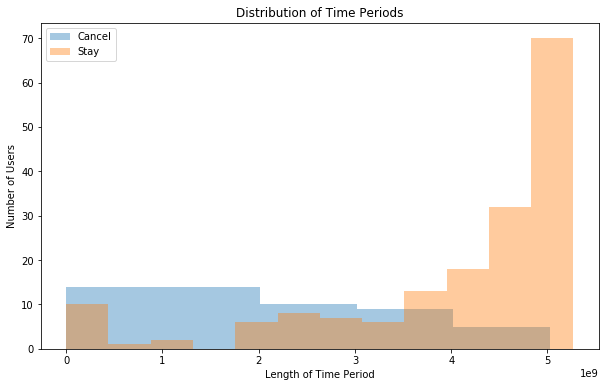

In [25]:
# Compare time-period distributions for cancelling/ non cancelling users
users_ts_sdf     = sdf.select('userId','ts').distinct()
users_maxts_sdf  = users_ts_sdf.groupby('userId').agg(F.max(users_ts_sdf.ts))
users_mints_sdf  = users_ts_sdf.groupby('userId').agg(F.min(users_ts_sdf.ts))
users_maxts_sdf  = users_maxts_sdf.withColumnRenamed('max(ts)','maxts')
users_mints_sdf  = users_mints_sdf.withColumnRenamed('min(ts)','mints')

users_mmts_sdf         = users_maxts_sdf.join(users_mints_sdf,on='userId',how= 'inner')

users_mmts_sdf = users_mmts_sdf.withColumn('ts_diff',users_mmts_sdf.maxts - users_mmts_sdf.mints)

users_mmts_cancel_sdf  = users_mmts_sdf.join(users_cancel_sdf,on='userId',how= 'inner')
users_mmts_stay_sdf    = users_mmts_sdf.join(users_stay_sdf,  on='userId',how= 'inner')

users_mmts_cancel_df   = users_mmts_cancel_sdf.toPandas()
users_mmts_stay_df     = users_mmts_stay_sdf.toPandas()


plt.figure(figsize=(10,6))
ax = sns.distplot(users_mmts_cancel_df.ts_diff, kde=False, label = "Cancel")
ax = sns.distplot(users_mmts_stay_df.ts_diff,   kde=False, label = "Stay")
ax.set(xlabel='Length of Time Period', ylabel='Number of Users',title = 'Distribution of Time Periods')
plt.legend()

In [26]:
# plt.figure(figsize=(10,6))
# ax = sns.distplot(users_mmts_cancel_df.ts_diff, kde=False, label = "Cancel")
# ax = sns.distplot(users_mmts_stay_df.ts_diff,   kde=False, label = "Stay")
# ax.set(xlabel='Length of Time Period', ylabel='Number of Users',title = 'Distribution of Time Periods')
# plt.legend()

#### The plot for the 'stay' set is completely expected of course but note that with longer time periods, the number of cancellations decreases. This may imply that the longer a user remains registered, the less likely they are to cancel. This is checked in the following cell.

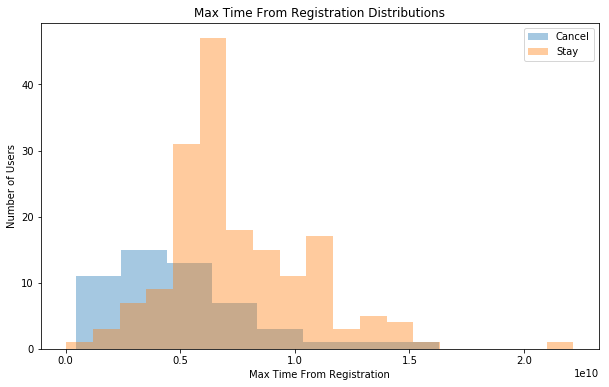

In [27]:
# Take time difference of user max time and their registration time
users_reg_sdf     = sdf.select('userId','registration').distinct()

reg_maxts_cancel_sdf     = users_reg_sdf.join(users_mmts_cancel_sdf,on='userId',how='inner')
reg_maxts_stay_sdf       = users_reg_sdf.join(users_mmts_stay_sdf,on='userId',how='inner')

reg_maxts_cancel_sdf = reg_maxts_cancel_sdf.withColumn('max_time_reg',
                                                       reg_maxts_cancel_sdf.maxts - reg_maxts_cancel_sdf.registration)

reg_maxts_stay_sdf = reg_maxts_stay_sdf.withColumn('max_time_reg',
                                                       reg_maxts_stay_sdf.maxts - reg_maxts_stay_sdf.registration)

reg_maxts_cancel_df =  reg_maxts_cancel_sdf.toPandas()
reg_maxts_stay_df   =  reg_maxts_stay_sdf.toPandas()

plt.figure(figsize=(10,6))
ax = sns.distplot(reg_maxts_cancel_df.max_time_reg, kde=False, label = "Cancel")
ax = sns.distplot(reg_maxts_stay_df.max_time_reg,   kde=False, label = "Stay")
ax.set(xlabel='Max Time From Registration', ylabel='Number of Users',title = 'Max Time From Registration Distributions')
plt.legend()

#### Note there is some separation in these distributions, so 'max time from registration' should be a very important feature for our model!

### 2.11 Field 'userAgent'

#### The user Agent field -- represents the platform (web browser, OS) used to access Sparkify, our streaming service.

In [28]:
# Breakdown userAgents in the cancel / stay sets
print("Number of unique userAgents:")
sdf.agg(F.countDistinct(sdf.userAgent)).show()

user_agents_sdf = sdf.select('userId','userAgent').distinct()
#print("Some Examples:")
#user_agents_sdf.show(10)

user_agents_cancel_sdf     = user_agents_sdf.join(users_cancel_sdf,on='userId',how='inner')
user_agents_stay_sdf       = user_agents_sdf.join(users_stay_sdf,  on='userId',how='inner')

## Agents both in cancel, stay
user_agents_cancelstay_sdf = user_agents_cancel_sdf.join(user_agents_stay_sdf, on='userAgent',how='inner').distinct()

#print(user_agents_cancelstay_sdf.count())## Users in cancel only
user_agents_cancelonly_sdf = user_agents_cancel_sdf.join(user_agents_cancelstay_sdf, on='userAgent',how='left_anti')
user_agents_stayonly_sdf = user_agents_stay_sdf.join(user_agents_cancelstay_sdf, on='userAgent',how='left_anti')


print("Number of unique Agents in cancel set:")
user_agents_cancel_sdf.agg(F.countDistinct(user_agents_cancel_sdf.userAgent)).show()

print("Number of unique Agents in stay   set")
user_agents_stay_sdf.agg(F.countDistinct(user_agents_stay_sdf.userAgent)).show()

print("Number of unique Agents in both  sets")
user_agents_cancelstay_sdf.agg(F.countDistinct(user_agents_cancelstay_sdf.userAgent)).show()

print("Number of unique Agents that appear only in the cancel set:")
user_agents_cancelonly_sdf.agg(F.countDistinct(user_agents_cancelonly_sdf.userAgent)).show()

print("Number of unique Agents that appear only  in the stay set:")
user_agents_stayonly_sdf.agg(F.countDistinct(user_agents_stayonly_sdf.userAgent)).show()

print("Number of unique users that appear in the cancel only set:")
user_agents_cancelonly_sdf.agg(F.countDistinct(user_agents_cancelonly_sdf.userId)).show()



Number of unique userAgents:
+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       56|
+-------------------------+

Number of unique Agents in cancel set:
+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       29|
+-------------------------+

Number of unique Agents in stay   set
+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       51|
+-------------------------+

Number of unique Agents in both  sets
+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                       24|
+-------------------------+

Number of unique Agents that appear only in the cancel set:
+-------------------------+
|count(DISTINCT userAgent)|
+-------------------------+
|                        5|
+-------------------------+

Number of unique Agents that appear only  in the stay set:
+-------------------------+
|cou

In [29]:
# Print some examples
user_agents_cancelonly_df = user_agents_cancelonly_sdf.toPandas()
print("userId=",user_agents_cancelonly_df.userId[0],"   ", user_agents_cancelonly_df.userAgent[0])
print("userId=",user_agents_cancelonly_df.userId[3],"   ", user_agents_cancelonly_df.userAgent[3])
print("userId=",user_agents_cancelonly_df.userId[4],"   ", user_agents_cancelonly_df.userAgent[4])


userId= 122     Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0
userId= 101     Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0
userId= 17     Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0


#### In the above we see that there are only 5 agents in the cancel only set, as opposed to 27 in the stay only set, and 24 that appear in both.

#### The 5 unique agents in the cancel only set correspond only to 5 unique users, this is so unbalanced that it is unlikely that the userAgent field could be useful.

### 2.12 Field 'location'

#### The location field describes the apparent city state of the userAgent. Below we breakdown the number of users in each state from the cancel and stay sets.

In [30]:
## The 'location' field -- describes city,state
sdf.select('userId','location').show(5)

+------+--------------------+
|userId|            location|
+------+--------------------+
|    30|     Bakersfield, CA|
|     9|Boston-Cambridge-...|
|    30|     Bakersfield, CA|
|     9|Boston-Cambridge-...|
|    30|     Bakersfield, CA|
+------+--------------------+
only showing top 5 rows



In [31]:
## Extract the last 2 letters as state acronym
def get_state(value):
    return value[-2:]

get_state_udf = udf(get_state, StringType())

user_loc_sdf  = sdf.select('userId','location').distinct() 

user_loc_sdf  = user_loc_sdf.withColumn("state", get_state_udf("location"))
user_loc_sdf.drop('location')

## Combine to stay,cancel sets
user_cancel_loc_sdf = user_loc_sdf.join(users_cancel_sdf,on='userId',how='inner')
user_stay_loc_sdf   = user_loc_sdf.join(users_stay_sdf,  on='userId',how='inner')

print("Cancelling Users State Count:")
print(user_cancel_loc_sdf.groupBy('state').count().orderBy('count',ascending=False).limit(15).toPandas())
print("Staying    Users State Count:")
print(user_stay_loc_sdf.groupBy('state').count().orderBy('count',ascending=False).limit(15).toPandas())


Cancelling Users State Count:
   state  count
0     CA      6
1     PA      5
2     FL      3
3     MD      3
4     MI      3
5     TX      3
6     AL      2
7     MS      2
8     CO      2
9     AZ      2
10    KY      2
11    OH      2
12    WA      2
13    NC      2
14    AR      2
Staying    Users State Count:
   state  count
0     CA     27
1     PA     13
2     TX     13
3     FL     11
4     WI      9
5     IL      8
6     SC      7
7     NC      7
8     NH      7
9     CT      7
10    IN      5
11    AZ      5
12    WV      5
13    MD      4
14    WA      4


#### Note users are spread all around the country, largest number of users in both sets are in the most populous states. For the states with the top counts, the ratio of counts in the cancel set to the stay set is very roughly the same ~ (1/3 - 1/4) as the ratio of cancelling users (52) to staying users (173) in the full data set. So location is likely not important.

In [32]:
# Drop userAgent, location
sdf = sdf.drop(*['userAgent','location'])

### 2.13 Field 'page'

#### This field represents the particular page type a user is visiting. To determine the relevance of page visits to user cancellations, we calculate the percentage of page visits in the cancel vs. stay sets.

In [33]:
# The 'page' field -- Examine the importance of how often a user accesses a type of page
# Calculate percentage of page visits in the cancelling vs. staying sets
users_page_sdf        = sdf.select('userId','page')

users_page_cancel_sdf = users_page_sdf.join(users_cancel_sdf,on='userId',how='inner')
users_page_stay_sdf   = users_page_sdf.join(users_stay_sdf,  on='userId',how='inner')

nupc = users_page_cancel_sdf.count()
nups = users_page_stay_sdf.count()

#users_page_cancel_sdf = \
#users_page_cancel_sdf.filter((users_page_cancel_sdf.page != 'Cancellation Confirmation') & (users_page_cancel_sdf.page != 'Cancel'))


users_page_cancel_df = \
    users_page_cancel_sdf.groupBy('page').count().orderBy('count',ascending=False).toPandas()
users_page_cancel_df.columns = ['page','percentage']
users_page_cancel_df.percentage = users_page_cancel_df.percentage/float(nupc) 


users_page_stay_df = \
    users_page_stay_sdf.groupBy('page').count().orderBy('count',ascending=False).toPandas()
users_page_stay_df.columns = ['page','percentage']
users_page_stay_df.percentage = users_page_stay_df.percentage/float(nups) 


print("Page visit percentanges for cancelling users:")
print(users_page_cancel_df)

print("Page visit percentanges for staying users:")
print(users_page_stay_df)


Page visit percentanges for cancelling users:
                         page  percentage
0                    NextSong    0.811207
1                   Thumbs Up    0.041436
2                        Home    0.037268
3             Add to Playlist    0.023137
4                 Roll Advert    0.021554
5                  Add Friend    0.014176
6                      Logout    0.012326
7                 Thumbs Down    0.011056
8                   Downgrade    0.007512
9                    Settings    0.006018
10                       Help    0.005327
11                    Upgrade    0.002496
12              Save Settings    0.001293
13                      About    0.001248
14                     Cancel    0.001159
15  Cancellation Confirmation    0.001159
16                      Error    0.000713
17             Submit Upgrade    0.000713
18           Submit Downgrade    0.000201
Page visit percentanges for staying users:
                page  percentage
0           NextSong    0.821784
1    

#### Note that the page visit percentages are remarkably similar, 

but accesses to but staying  users accessed the 'Thumbs Down' page slightly less and the 'Thumbs Up' page slightly more than cancelling users. The same is true for  'Add Friend'. 
This prompts us to create histograms of these page percentages aggregated up to the user. 

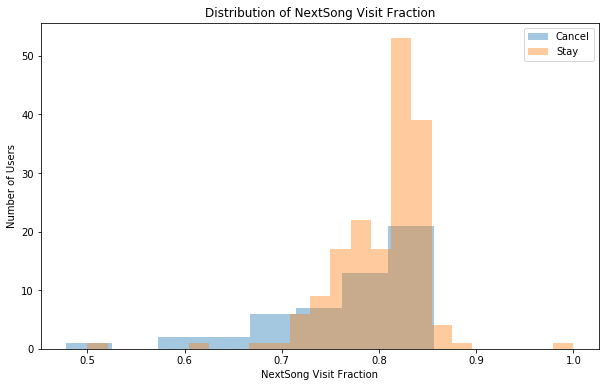

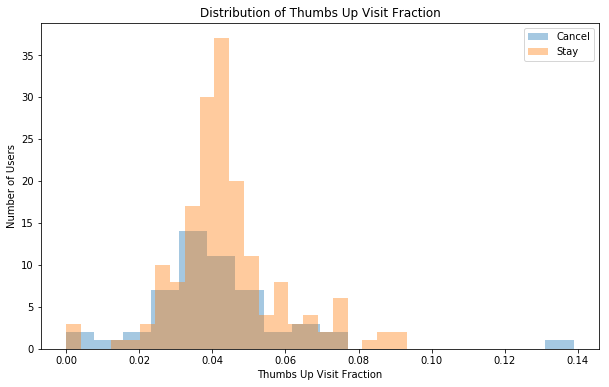

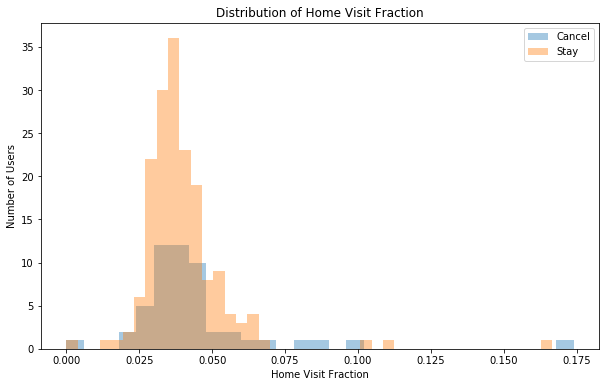

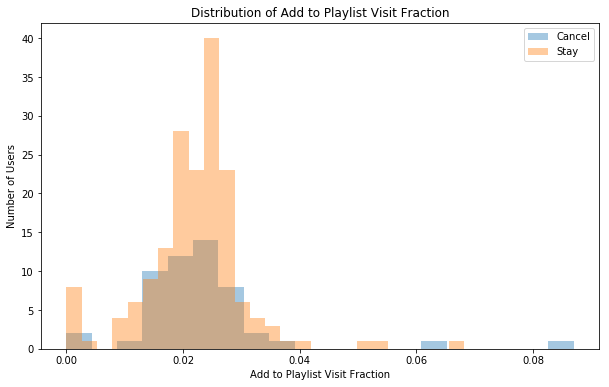

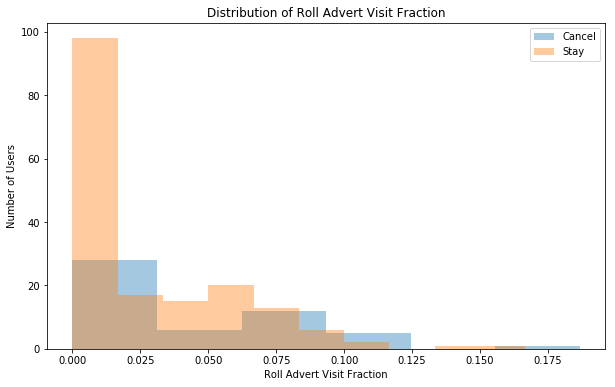

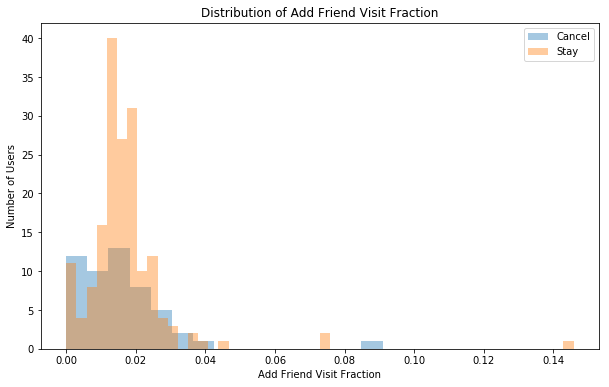

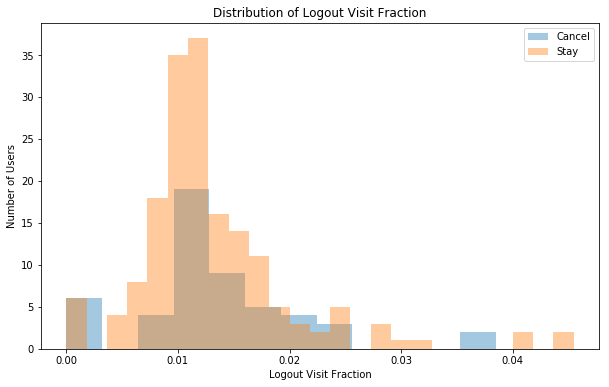

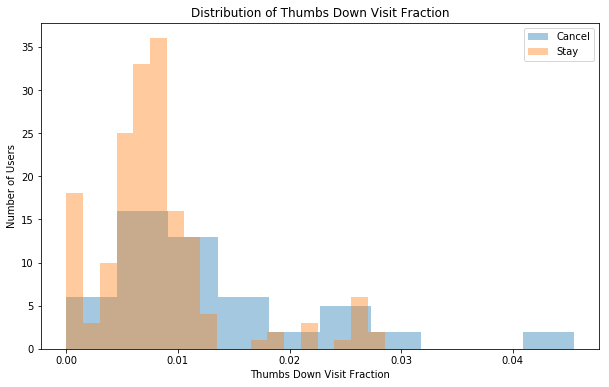

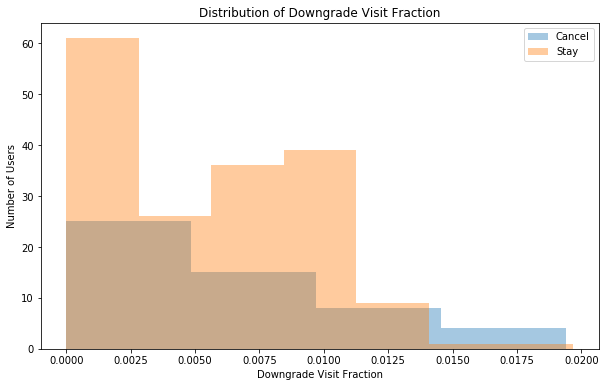

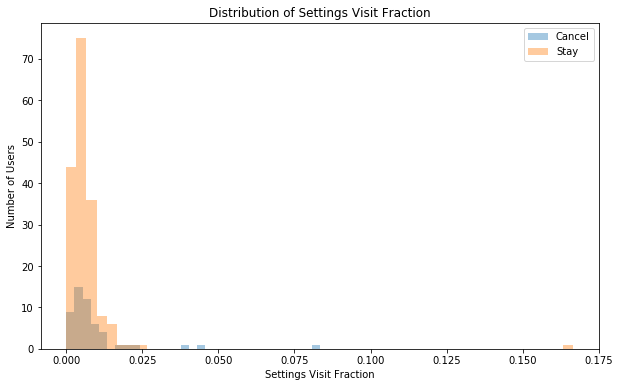

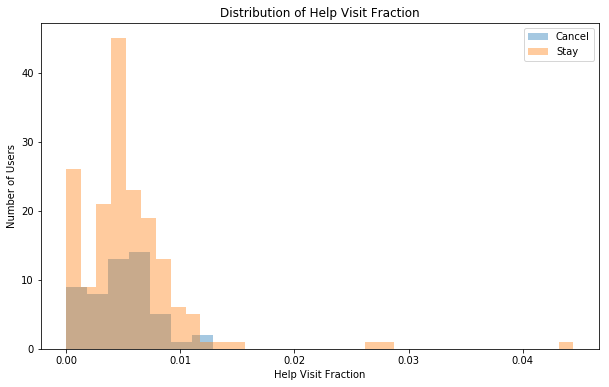

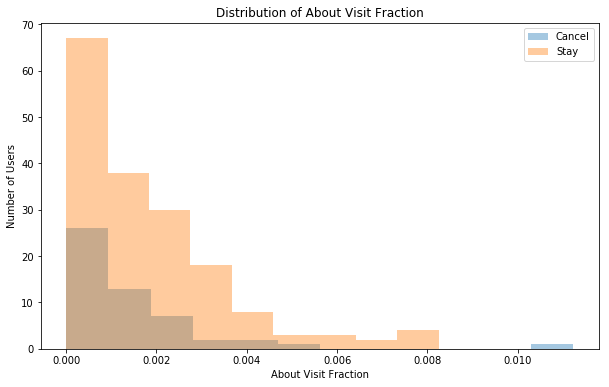

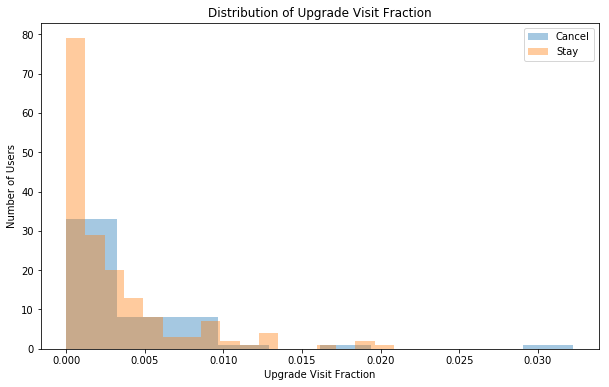

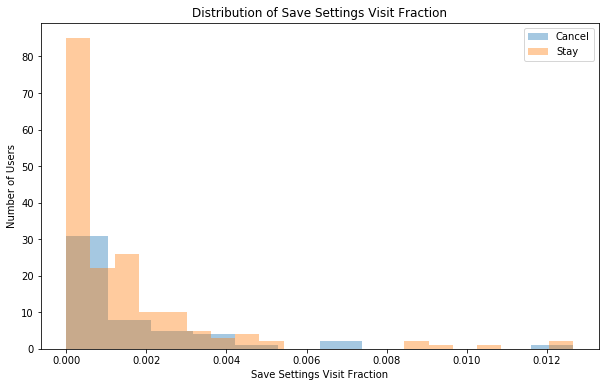

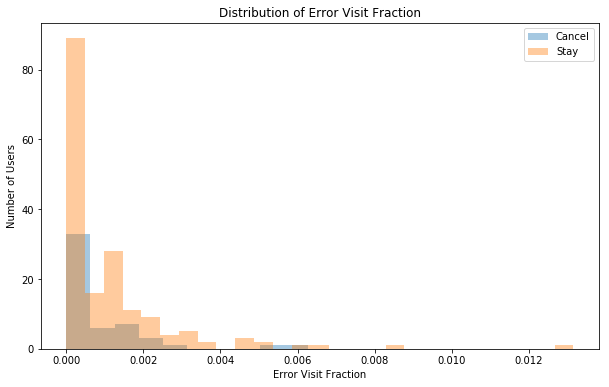

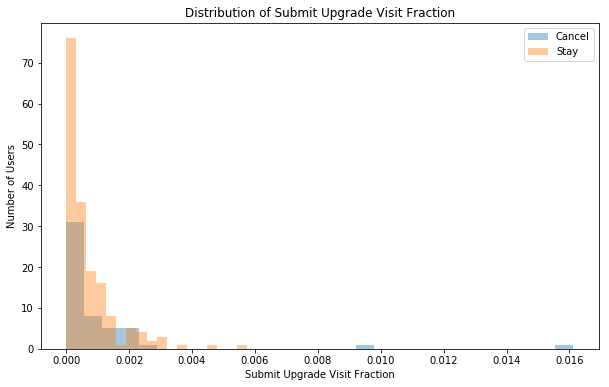

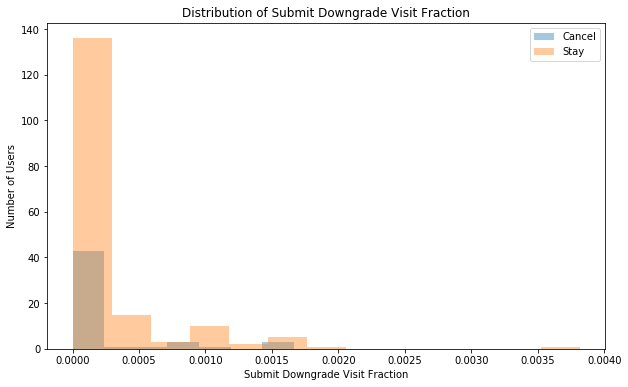

In [34]:
## Construct histograms of users vs. pg visit fraction
pages = ['NextSong','Thumbs Up','Home','Add to Playlist','Roll Advert','Add Friend','Logout','Thumbs Down','Downgrade','Settings',
         'Help','About','Upgrade','Save Settings','Error','Submit Upgrade','Submit Downgrade']

users_page_stay_sdf   = users_page_stay_sdf.withColumn('pvisit',lit(0))
users_page_cancel_sdf = users_page_cancel_sdf.withColumn('pvisit',lit(0))


for page in pages:
    
    users_page_stay_sdf  = users_page_stay_sdf   \
                        .withColumn('pvisit',F.when(F.col('page')==page,lit(1)).otherwise(lit(0)))
    users_page_cancel_sdf  = users_page_cancel_sdf   \
                        .withColumn('pvisit',F.when(F.col('page')==page,lit(1)).otherwise(lit(0)))
    
    users_pgfrac_stay_sdf   = users_page_stay_sdf.groupby('userId').agg({'pvisit' : 'mean'})
    users_pgfrac_cancel_sdf = users_page_cancel_sdf.groupby('userId').agg({'pvisit' : 'mean'})
    
        
    users_pgfrac_stay_df    = users_pgfrac_stay_sdf.toPandas()
    users_pgfrac_cancel_df  = users_pgfrac_cancel_sdf.toPandas()
    
    users_pgfrac_stay_df.columns   = ['userId',page]
    users_pgfrac_cancel_df.columns = ['userId',page]
    
    plt.figure(figsize=(10,6)) 
    ax = sns.distplot(users_pgfrac_cancel_df[page], kde=False, label = 'Cancel')
    ax = sns.distplot(users_pgfrac_stay_df[page],   kde=False, label = 'Stay')
    xlb = page + ' Visit Fraction'
    ax.set(xlabel=xlb, ylabel='Number of Users',title = 'Distribution of ' + xlb)
    plt.legend()


#### Very little daylight between any of these!! The best we can do is to select 'NextSong' and 'Thumbs Down' page fraction as additional features for our model.

### 2.14 Field 'length' 

#### The length field appears to be the length of the corresponding song (from the 'song' field) in seconds. We can use this field to calculate an "estimate" of the amount of a user listens to content on the service, essentially the ratio of the sum of 'length' for a user divided by the difference of max and min timestamps.

#### It is important to note that this is just an estimate (quite poor in a few cases) since not every user will listen to a song the entire way through every time, and for nonpaying users songs are interrupted by advertisements. We see in the distribution plots of this ratio in fact that in some outlier cases the ratio is larger than one.

In [35]:
# Compute for each userId, ratio = sum(length)/(max(ts) - min(ts))
listen_tf_sdf = sdf.select('userId','ts','length')
listen_tf_sdf = listen_tf_sdf.fillna({'length':0.0})

listen_tf_sdf = listen_tf_sdf.groupby("userId").agg(F.min(listen_tf_sdf.ts),
                                                    F.max(listen_tf_sdf.ts),
                                                    F.sum(listen_tf_sdf.length))

listen_tf_sdf = listen_tf_sdf.withColumn('ratio',col('sum(length)')*1000.0/(col('max(ts)') - col('min(ts)')))
listen_tf_sdf = listen_tf_sdf.select('userId','ratio')
listen_tf_stay_df   = listen_tf_sdf.join(users_stay_sdf,on='userId',how='inner').toPandas()
listen_tf_cancel_df = listen_tf_sdf.join(users_cancel_sdf,on='userId',how='inner').toPandas()


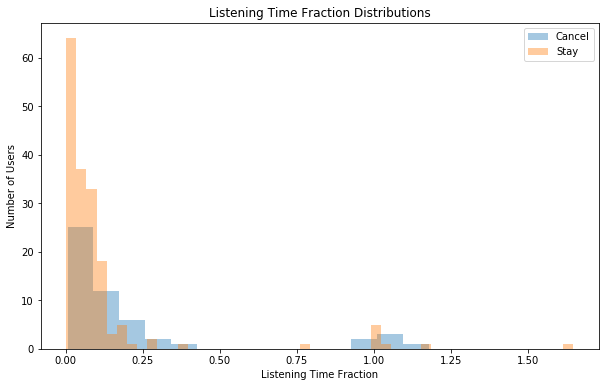

In [36]:
plt.figure(figsize=(10,6))
ax = sns.distplot(listen_tf_cancel_df.ratio, kde=False, label = 'Cancel')
ax = sns.distplot(listen_tf_stay_df.ratio,   kde=False, label = 'Stay')
ax.set(xlabel="Listening Time Fraction", ylabel='Number of Users',title = "Listening Time Fraction Distributions")
plt.legend()

### 2.15 Field 'sessionId'

#### We saw above, that multiple users can have the same sessionId. However, assuming that the sessionId is a meaningful marker, it might make sense to attempt compute histograms for the number of songs listened to per sessionId.

In [37]:
listen_session_sdf = sdf.select('userId','sessionId','page').filter(sdf.page=='NextSong')
listen_session_sdf = listen_session_sdf.drop('page')
listen_session_sdf = listen_session_sdf.groupby('userId','sessionId').count()
listen_session_sdf = listen_session_sdf.withColumnRenamed('count','cnt')
listen_session_sdf = listen_session_sdf.groupby('userId').agg(F.avg(listen_session_sdf.cnt))
   

listen_session_stay_df   = listen_session_sdf.join(users_stay_sdf,on='userId',  how='inner').toPandas()
listen_session_cancel_df = listen_session_sdf.join(users_cancel_sdf,on='userId',how='inner').toPandas()
listen_session_stay_df.columns   = ['userId','songs_session']
listen_session_cancel_df.columns = ['userId','songs_session']

In [38]:
#listen_session_stay_df.columns

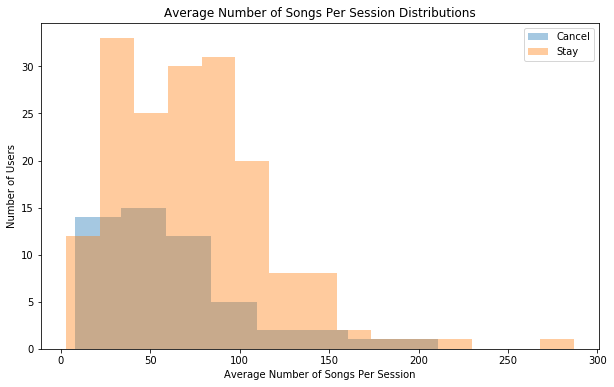

In [39]:
plt.figure(figsize=(10,6))
ax = sns.distplot(listen_session_cancel_df.songs_session, kde=False, label = 'Cancel')
ax = sns.distplot(listen_session_stay_df.songs_session,   kde=False, label = 'Stay')
ax.set(xlabel="Average Number of Songs Per Session", ylabel='Number of Users',title = "Average Number of Songs Per Session Distributions")
plt.legend()

## 3 Feature Engineering

#### From the above analysis, the following features have been selected to construct our prediction model:

     * Max time from registration
     * Fraction of Thumbs Down accesses
     * Fraction of NextSong accesses
     * Gender
     * Average 'paid' level

In [40]:
sdf_feat = spark.read.json('mini_sparkify_event_data.json') ## Read into Spark Dataframe
sdf_feat.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

### 3.1 Feature Selection

#### Build out the Feature Matrix

In [41]:
## Could also free/paid fraction
sdf_feat = sdf_feat.select('userId','page','gender','ts','registration','level')
sdf_feat = sdf_feat.filter(sdf_feat.userId != '')


tdn_udf = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())
nxs_udf = udf(lambda x: 1 if x == "NextSong"    else 0, IntegerType())
gen_udf = udf(lambda x: 1 if x == "M"           else 0, IntegerType())
chn_udf = udf(lambda x: 1 if x == "Cancellation Confirmation"   else 0, IntegerType())
lvl_udf = udf(lambda x: 1 if x == "paid"   else 0, IntegerType())

## Add marker columns to perform aggregation
features_sdf =  sdf_feat.withColumn('TDNm', tdn_udf("page"))   \
                        .withColumn('NSm',  nxs_udf("page"))   \
                        .withColumn('gm',   gen_udf("gender")) \
                        .withColumn('chnm', chn_udf("page"))   \
                        .withColumn('lvlm', lvl_udf("level"))


features_sdf =  features_sdf.groupby("userId").agg(F.avg(features_sdf.TDNm),
                                                   F.avg(features_sdf.NSm),
                                                   F.max(features_sdf.gm),
                                                   F.max(features_sdf.registration),
                                                   F.max(features_sdf.ts),
                                                   F.avg(features_sdf.lvlm),
                                                   F.max(features_sdf.chnm))

                               
## Compute max time reg difference
features_sdf = features_sdf.withColumn('max_time_reg',(col('max(ts)')  - col('max(registration)')))
features_sdf = features_sdf.drop(*['max(ts)','max(registration)'])

# Reset column names
old_names = ['max(chnm)','max(gm)','avg(NSm)','avg(TDNm)','avg(lvlm)']
new_names = ['churn','gender_m','NextSong','ThumbsDown','level_p']
features_sdf = reduce(lambda features_sdf, idx: features_sdf.withColumnRenamed(old_names[idx], new_names[idx]), range(len(old_names)), features_sdf)
features_sdf.printSchema()

features_sdf.show(10)


root
 |-- userId: string (nullable = true)
 |-- ThumbsDown: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- gender_m: integer (nullable = true)
 |-- level_p: double (nullable = true)
 |-- churn: integer (nullable = true)
 |-- max_time_reg: long (nullable = true)

+------+--------------------+------------------+--------+------------------+-----+------------+
|userId|          ThumbsDown|          NextSong|gender_m|           level_p|churn|max_time_reg|
+------+--------------------+------------------+--------+------------------+-----+------------+
|100010|0.013123359580052493|0.7217847769028871|       0|               0.0|    0|  4807612000|
|200002|0.012658227848101266|0.8164556962025317|       1|0.7468354430379747|    0|  6054448000|
|   125|                 0.0|0.7272727272727273|       1|               0.0|    1|  6161779000|
|    51|0.008522727272727272| 0.856737012987013|       1|               1.0|    1|  1680985000|
|   124| 0.00849740932642487|0.84538860103

### 3.2 Train / Test Data Split

#### As seen before, the data set is very unbalanced with many more users staying with the Sparkify service than leaving.

In [42]:
# Print cancel to stay, or churn, ratio
print("Percentage of Users in Churn:")
cs_ratio = features_sdf.select(F.mean(col('churn'))).toPandas()['avg(churn)'].values[0]
print(cs_ratio)

Percentage of Users in Churn:
0.231111111111


#### Split features_sdf into train/test sets in the normal fashion would likely leave very few and perhaps not any test data with churn=1, so we choose to undersample the train data.

#### First we'll select an equal number samples from the churn=0,1 sets. Then we allow an add back of some churn=0 data. We expect that allowing a 'slight' imbalance in the data in favor of adding more data will ultimately improve the model.

In [43]:
# Split features_sdf into train/test sets 
train_frac          = 0.8
sc_ratio_train_frac = 1.6 ## This provides a little add back of churn=0 (stay) data


## First we have to split into cancel and stay sets
features_stay_sdf      = features_sdf.filter(features_sdf.churn==0)
features_cancel_sdf    = features_sdf.filter(features_sdf.churn==1)

## Split cancel to train/test
features_train_cancel_sdf = features_cancel_sdf.sample(False, train_frac, seed=48)
features_test_cancel_sdf  = features_cancel_sdf.join(features_train_cancel_sdf.select('userId'),on='userId',
                                                    how = 'left_anti')
## Split stay to train/test
features_train_stay_sdf = features_stay_sdf.sample(False, cs_ratio*train_frac*sc_ratio_train_frac, seed=480)
features_test_stay_sdf  = features_stay_sdf.join(features_train_stay_sdf.select('userId'),on='userId',
                                                    how = 'left_anti')

## Reassemble to train/test
features_train_sdf = features_train_cancel_sdf.union(features_train_stay_sdf)
features_test_sdf  = features_test_cancel_sdf.union(features_test_stay_sdf)


# Print number of users in each set
print("Number of cancelling users in train set = ", features_train_cancel_sdf.count())
print("Number of staying    users in train set = ", features_train_stay_sdf.count())
print("Number of cancelling users in test set = ",  features_test_cancel_sdf.count())
print("Number of staying    users in test set = ",  features_test_stay_sdf.count())


Number of cancelling users in train set =  41
Number of staying    users in train set =  55
Number of cancelling users in test set =  11
Number of staying    users in test set =  118


## 4 Initial Model Runs and Comparison

#### We compare the performance of the DecisionTree and Random Forest classifiers as each is  a good all-purpose classifier for mixed discrete and continuous data. 

In [44]:
# Construct pipeline function for model
def construct_pipeline(feature_cols,classifier):
    """
    Constructs a pyspark ML Pipeline object assuming multiple features, contains data scaling
    and the classifier object.
    
    Input: feature_cols: list of column names for features to be used
           classifier:   pyspark ML classifier instance
    
    Output: pyspark ML Pipeline object
    
    """
        
    featureAssembler = VectorAssembler(inputCols=feature_cols, outputCol="featuresAssemble")
    
    stringIndexer = StringIndexer(inputCol="churn", outputCol="label")
    
    scaler = MinMaxScaler(inputCol="featuresAssemble", outputCol="features")

    pipeline = Pipeline(stages=[featureAssembler, stringIndexer, scaler, classifier])  

    return pipeline 


In [45]:
# Print metrics, results for model run
def print_metrics(label,metrics):
    """
    Prints precision,recall, f1 score, and confustion matrix from metrics
    calculated from binary classification problem, label is 0 or 1.
    
    Input: label: a string to label the metrics printed here
    
    Output: metrics: metrics object of type pyspark.mllib.evaluation::MulticlassMetrics
    
    """
    
    print("=========", label, "==========")
    print("Accuracy = ",metrics.accuracy)
    print("Stay     Precision = ",metrics.precision(label=0))
    print("Cancel   Precision = ",metrics.precision(label=1))
    print("Stay     Recall    = ",metrics.recall(label=0))
    print("Cancel   Recall    = ",metrics.recall(label=1))
    ## Here, beta weights precision vs. recall in the harmonic mean in f1.
    ## beta=1.0 corresponds to equal weighting.
    print("Stay     F1 Measure= ",metrics.fMeasure(label=0.0,beta=1.0))
    print("Cancel   F1 Measure= ",metrics.fMeasure(label=1.0,beta=1.0))
    ##
    print("Confusion Matrix")
    print(metrics.confusionMatrix())


In [46]:
## Compare the classifiers
classifiers = [DecisionTreeClassifier(seed=42),RandomForestClassifier(seed=42)]
classifier_names = ["DecisionTree","RandomForest"]

feature_cols = ['ThumbsDown','NextSong','max_time_reg','gender_m','level_p']

for classifier,classifier_name in zip(classifiers,classifier_names):
    
    print(classifier_name)
    pipe = construct_pipeline(feature_cols,classifier)
    model = pipe.fit(features_train_sdf)
    train_predict = model.transform(features_train_sdf)
    test_predict  = model.transform(features_test_sdf)
    train_metrics = MulticlassMetrics(train_predict.select(['prediction','label']).rdd)
    test_metrics  = MulticlassMetrics(test_predict.select(['prediction','label']).rdd)
    print("Metrics -- ")
    met_name = classifier_name + " Training Metrics"; print_metrics(met_name,train_metrics)
    met_name = classifier_name + " Testing  Metrics"; print_metrics(met_name,test_metrics)


DecisionTree
Metrics -- 
========= DecisionTree Training Metrics ==========
Accuracy =  0.90625
Stay     Precision =  0.859375
Cancel   Precision =  1.0
Stay     Recall    =  1.0
Cancel   Recall    =  0.7804878048780488
Stay     F1 Measure=  0.9243697478991597
Cancel   F1 Measure=  0.8767123287671234
Confusion Matrix
DenseMatrix([[ 55.,   0.],
             [  9.,  32.]])
========= DecisionTree Testing  Metrics ==========
Accuracy =  0.7829457364341085
Stay     Precision =  0.9591836734693877
Cancel   Precision =  0.22580645161290322
Stay     Recall    =  0.7966101694915254
Cancel   Recall    =  0.6363636363636364
Stay     F1 Measure=  0.8703703703703702
Cancel   F1 Measure=  0.3333333333333333
Confusion Matrix
DenseMatrix([[ 94.,  24.],
             [  4.,   7.]])
RandomForest
Metrics -- 
========= RandomForest Training Metrics ==========
Accuracy =  0.9166666666666666
Stay     Precision =  0.873015873015873
Cancel   Precision =  1.0
Stay     Recall    =  1.0
Cancel   Recall    =  0.80

## 5 Model Tuning

### 5.1 Tune Selected Model

In [47]:
# Tune RandomForest against data
rfc = RandomForestClassifier(seed=42)
pipe  = construct_pipeline(feature_cols, rfc)

# Default optimization for this evaluator (according to documentation)
# is 'f1' score
evaluator = MulticlassClassificationEvaluator()
# evaluator = BinaryClassificationEvaluator()

param_grid = ParamGridBuilder().addGrid(rfc.numTrees,[10,15,20,24]) \
                               .addGrid(rfc.minInstancesPerNode,[1,2])  \
                               .addGrid(rfc.maxDepth,[5,7]) \
                               .addGrid(rfc.seed,[42]).build()


cross_validator = CrossValidator(estimator=pipe, estimatorParamMaps=param_grid,
                                 evaluator=evaluator,
                                 numFolds=3,
                                 seed=42)


# train model
print("Running Tuning Train Step ...")
t0 = time.time()
model = cross_validator.fit(features_train_sdf)
print("Took ... ",((time.time() - t0)/60.0)," minutes.")

# test data prediction
t0 = time.time()
print("Running Tuning Test Prediction Step ...")
test_predict  = model.transform(features_test_sdf)
print("Took ... ",((time.time() - t0))," seconds.")
      
# Extract test metrics
t0 = time.time()
print("Extracting Tuning Test Metrics ...")
test_metrics  = MulticlassMetrics(test_predict.select(['prediction','label']).rdd)
print("Took ... ",((time.time() - t0))," seconds.")
met_name = "Random Forest Optimized Test Metrics"; print_metrics(met_name,test_metrics)


Running Tuning Train Step ...
Took ...  44.850341248512265  minutes.
Running Tuning Test Prediction Step ...
Took ...  0.09079194068908691  seconds.
Extracting Tuning Test Metrics ...
Took ...  3.7339224815368652  seconds.
========= Random Forest Optimized Test Metrics ==========
Accuracy =  0.7441860465116279
Stay     Precision =  0.967032967032967
Cancel   Precision =  0.21052631578947367
Stay     Recall    =  0.7457627118644068
Cancel   Recall    =  0.7272727272727273
Stay     F1 Measure=  0.8421052631578948
Cancel   F1 Measure=  0.32653061224489793
Confusion Matrix
DenseMatrix([[ 88.,  30.],
             [  3.,   8.]])


### 5.2 Best Model Parameters

In [48]:
model.bestModel.stages[3].extractParamMap()

{Param(parent='RandomForestClassifier_049a1c2556dc', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_049a1c2556dc', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_049a1c2556dc', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_049a1c2556dc', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_049a1c2556dc', 

## 6 Final Reflections

We were unable to better the F1 score beyond 0.34, which although not very good, is at least partially explained by having much less data for cancelling users compared to those not cancelling.

#### Eight out of the eleven cancelling users and 90 out of 118 staying users in the test set were predicted correctly, a somewhat decent result.

Although our feature analysis for this study was fairly thorough, it was by no means exhaustive. To make further progress, we believe it would be crucial to properly account for how the user is spending time on the site. This means precisely calculating how much time they spend time on each page, how frequently they visit each page, and how much that frequency changes over time. For example, the time spent listening songs could be calculated by taking differences of the time stamp between rows for a user where contiguous section of page="NextSong" is found for that user. This is much more precise than just using the song length as we did here.

Another improvement would be to remove outliers, like those we saw far to the right in the page fraction histogram plots.